In [4]:
import warnings
warnings.filterwarnings("ignore")
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


# **Data Preprocessing**

* #  **Read data and store it in dataframe**

In [5]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# print(labels)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [7]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


* #  **Split dataframe into train, valid, and test**

In [9]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [10]:
test_df

,filepaths,labels
569,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
822,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1056,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
84,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
560,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
692,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1032,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1044,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
237,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


* #  **create image data generator**

In [11]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


* # **Show sample from train data**

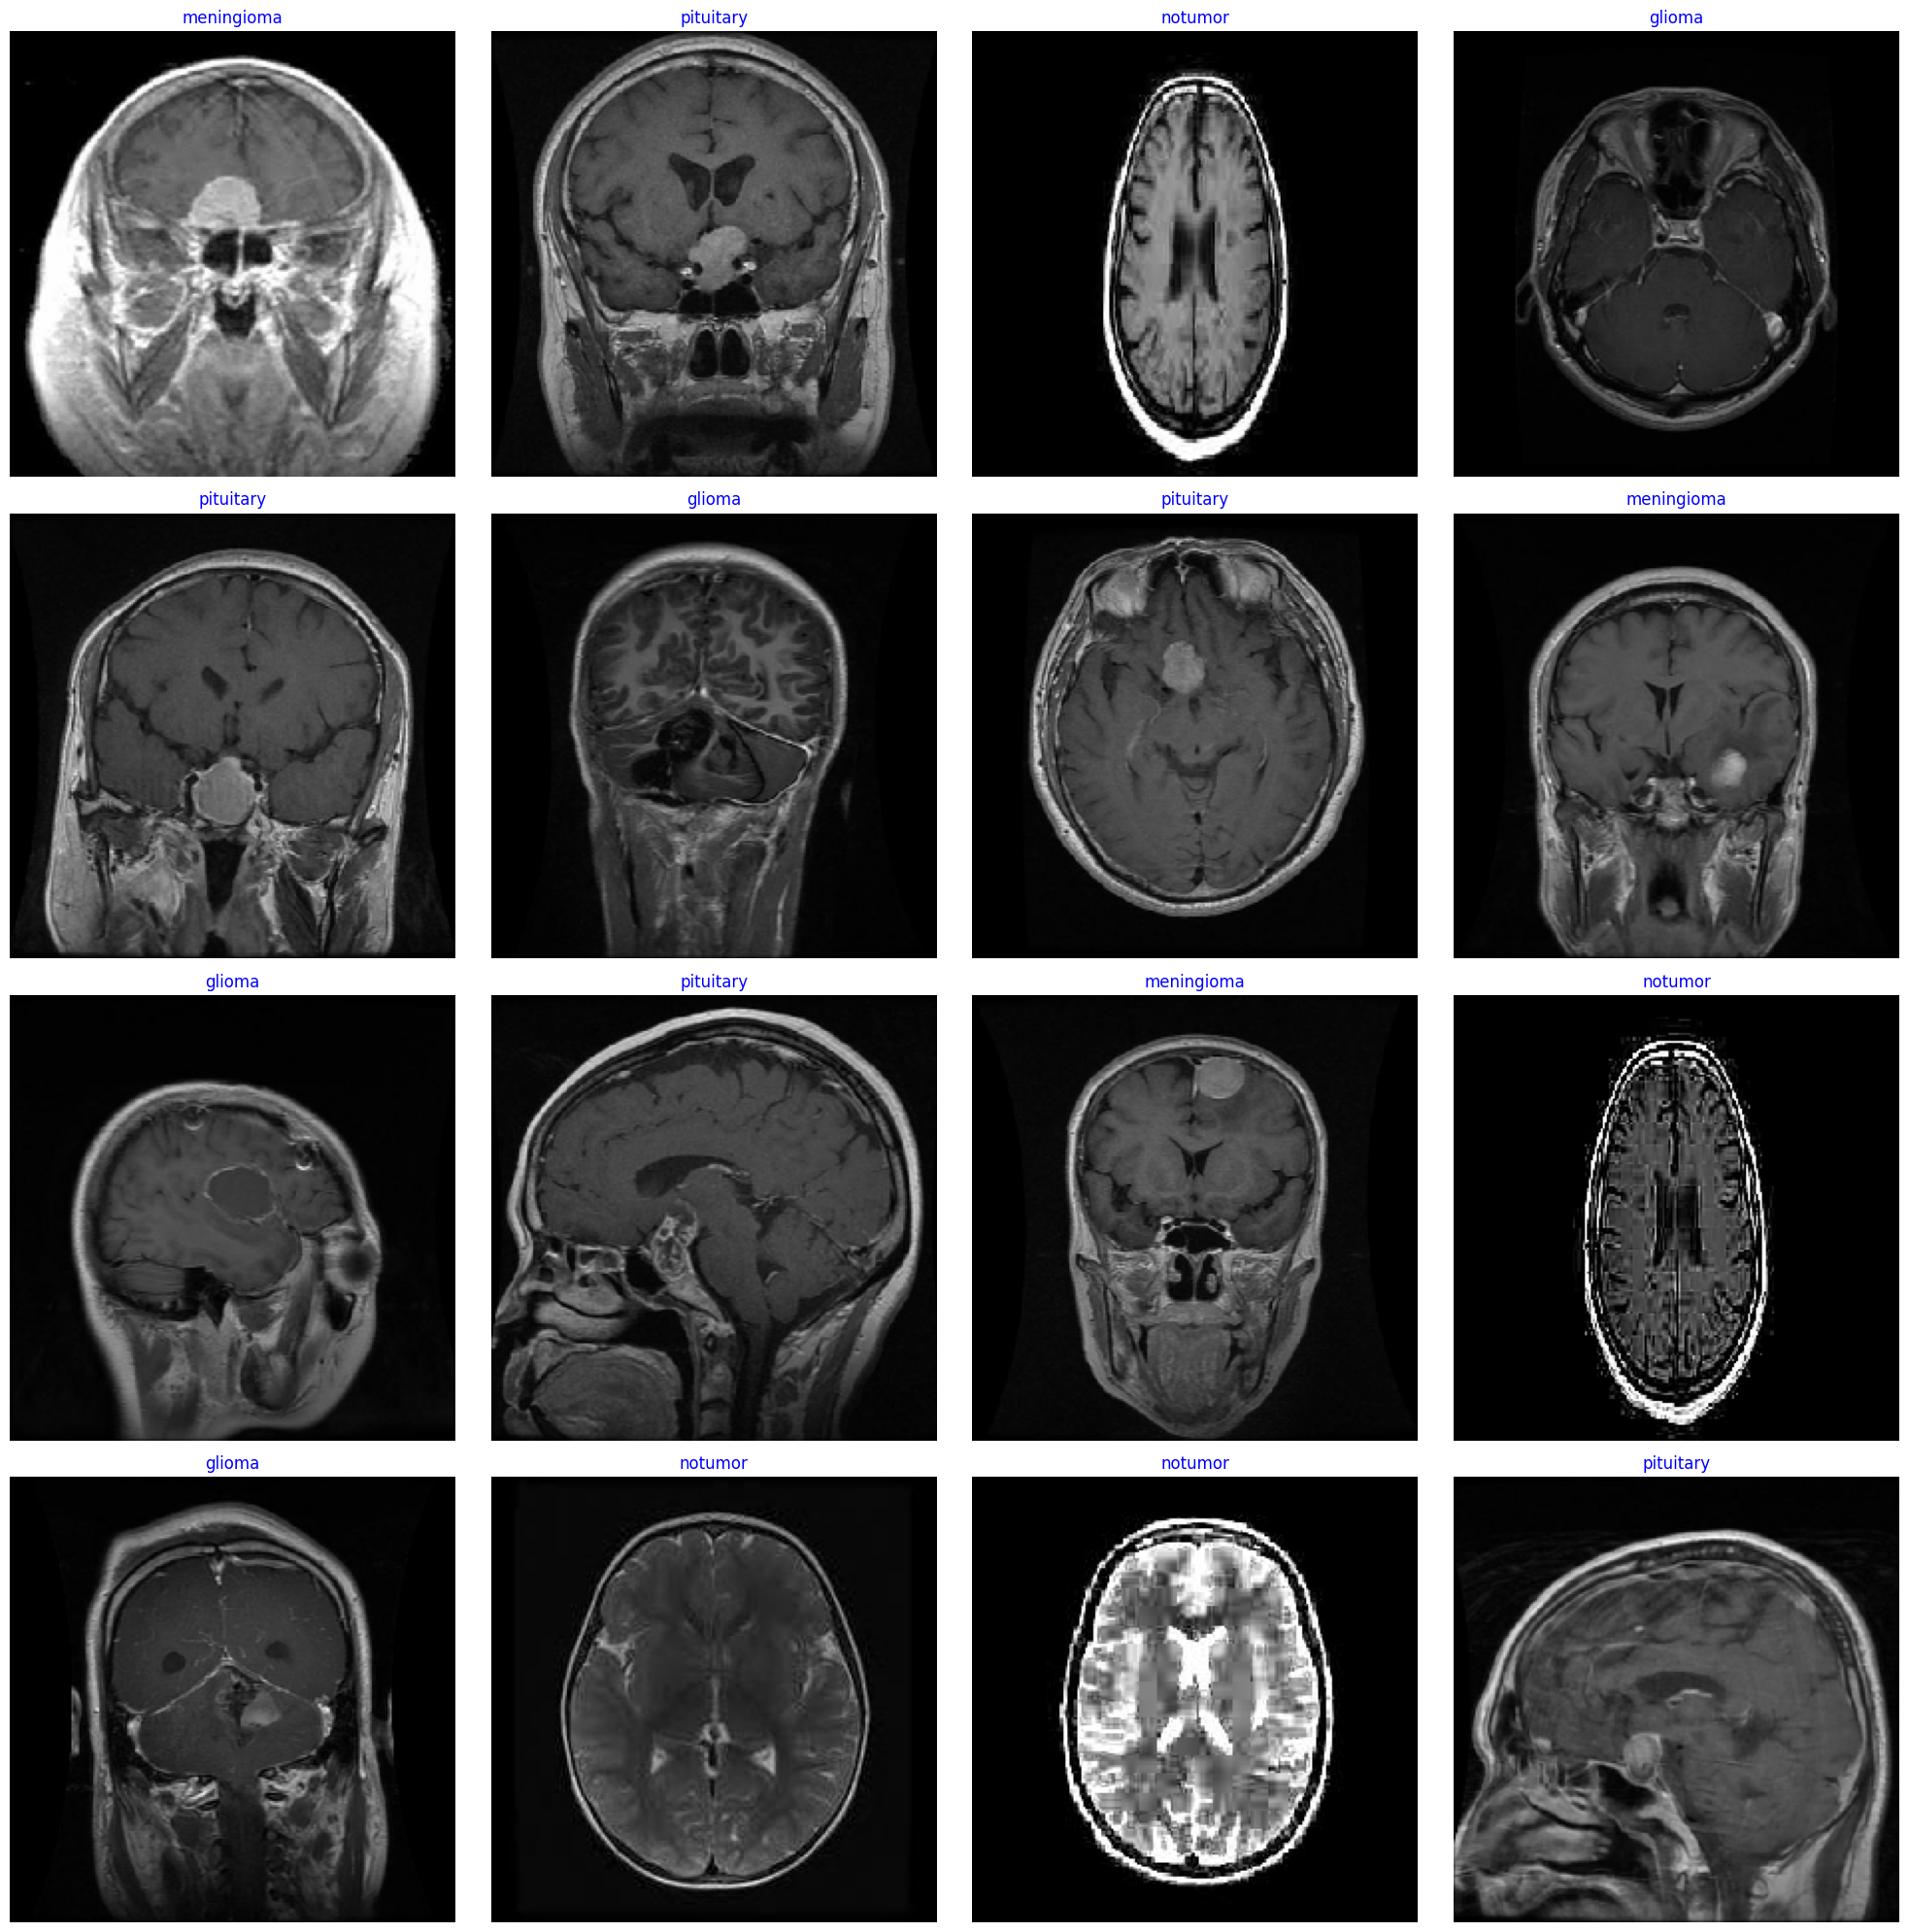

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adamax

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) 

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape= img_shape),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation=LeakyReLU(alpha=0.1)),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                    

In [14]:
epochs = 30

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30
357/357 [==============================] - 60s 145ms/step - loss: 0.9999 - accuracy: 0.5473 - val_loss: 0.7175 - val_accuracy: 0.6916
Epoch 2/30
357/357 [==============================] - 20s 56ms/step - loss: 0.5440 - accuracy: 0.7787 - val_loss: 0.5713 - val_accuracy: 0.7542
Epoch 3/30
357/357 [==============================] - 19s 52ms/step - loss: 0.3887 - accuracy: 0.8501 - val_loss: 0.4766 - val_accuracy: 0.8214
Epoch 4/30
357/357 [==============================] - 19s 53ms/step - loss: 0.2874 - accuracy: 0.8974 - val_loss: 0.3074 - val_accuracy: 0.8763
Epoch 5/30
357/357 [==============================] - 19s 53ms/step - loss: 0.2124 - accuracy: 0.9219 - val_loss: 0.2982 - val_accuracy: 0.9038
Epoch 6/30
357/357 [==============================] - 18s 52ms/step - loss: 0.1640 - accuracy: 0.9417 - val_loss: 0.3086 - val_accuracy: 0.8947
Epoch 7/30
357/357 [==============================] - 19s 53ms/step - loss: 0.1299 - accuracy: 0.9531 - val_loss: 0.2582 - val_accuracy

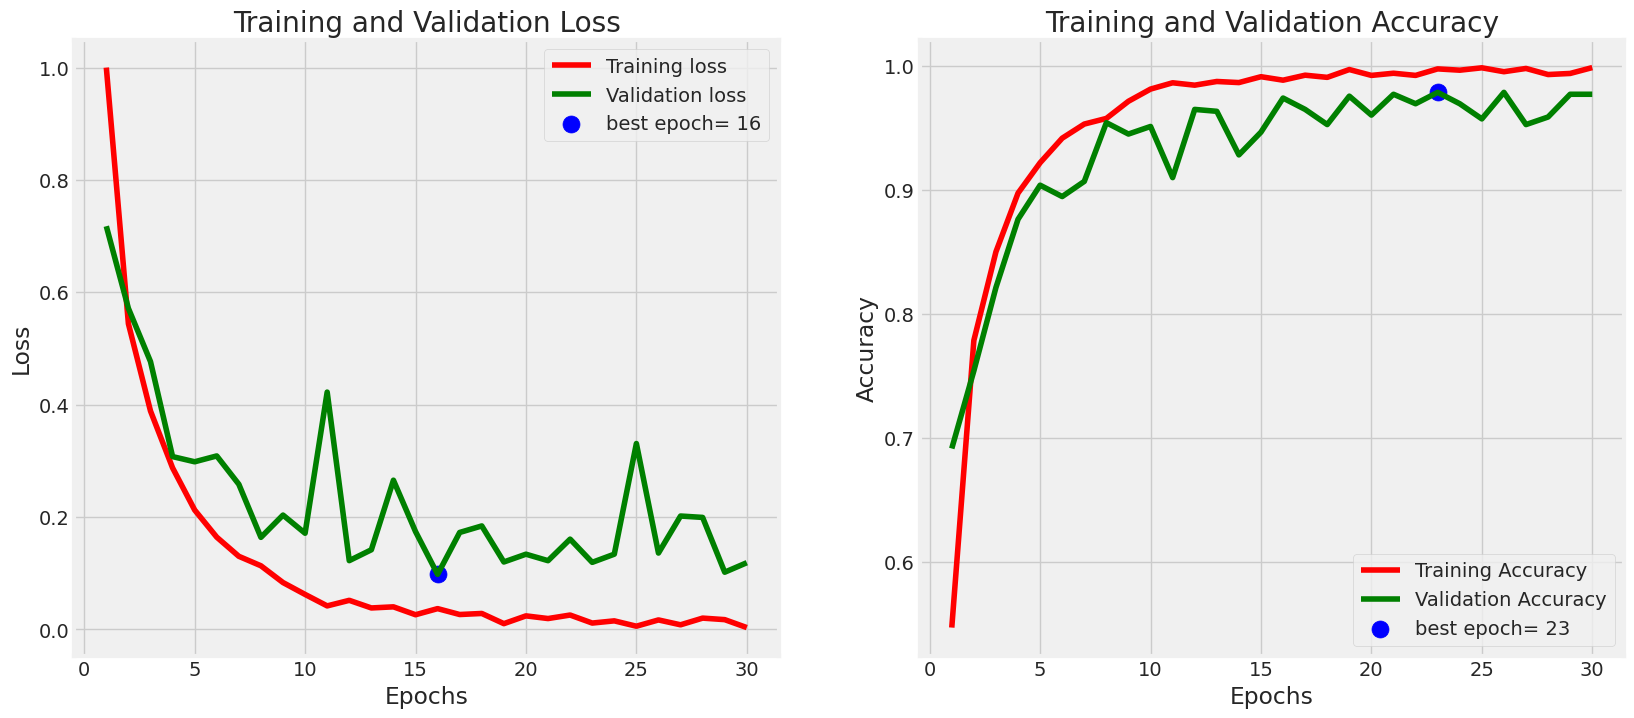

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 5s 121ms/step - loss: 0.1661 - accuracy: 0.9649
Train Loss:  0.004287493880838156
Train Accuracy:  0.998774528503418
--------------------
Validation Loss:  0.1185552254319191
Validation Accuracy:  0.9770992398262024
--------------------
Test Loss:  0.16612617671489716
Test Accuracy:  0.9649389982223511


In [17]:
preds = model.predict_generator(test_gen)    # [[0.001, 0.97, 0.01, 0.009], [], [], ]
y_pred = np.argmax(preds, axis=1)            # [1, 2, 0, 2, 3]

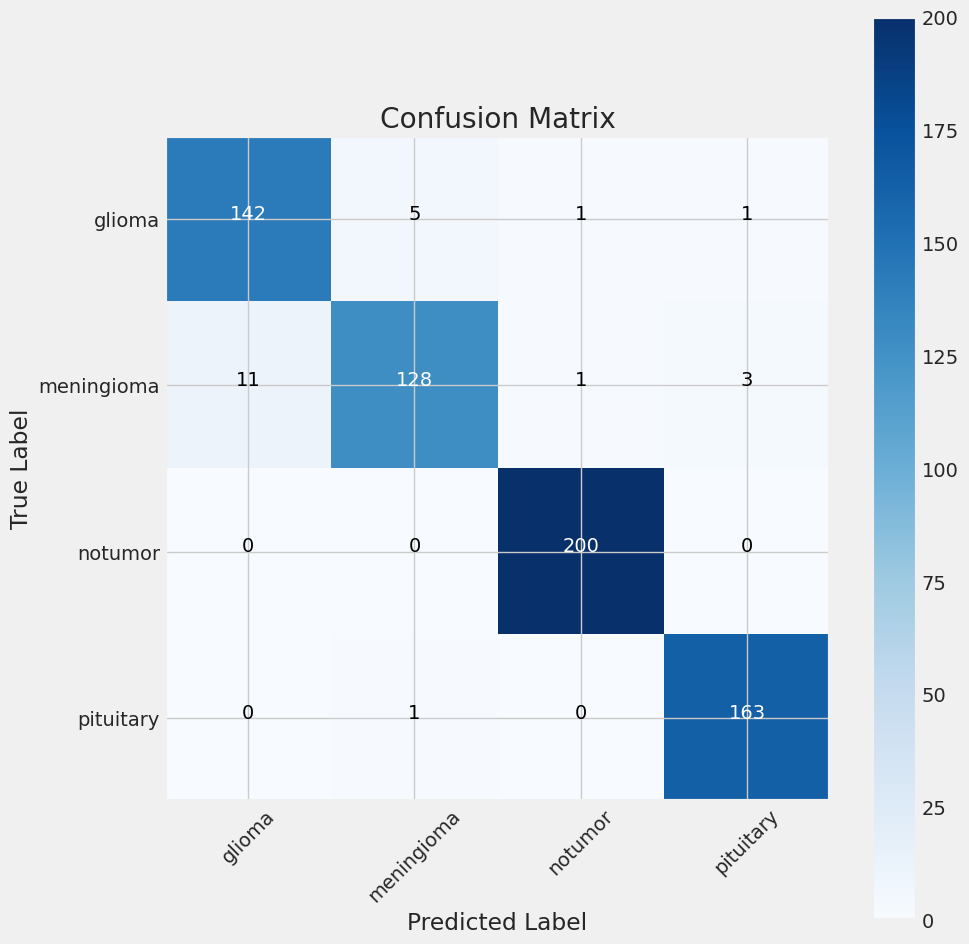

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.93      0.95      0.94       149
  meningioma       0.96      0.90      0.92       143
     notumor       0.99      1.00      1.00       200
   pituitary       0.98      0.99      0.98       164

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [20]:
#Save the model
model.save('Brain Tumors.h5')

In [21]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Brain Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [22]:
image_path = '/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(1).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print(f"{class_labels[np.argmax(predictions)]}")

1/1 [==============================] - 0s 397ms/step
Pituitary
